Trước khi run pip, cài đặt các thư viện bằng câu lệnh sau
```
pip install pandas numpy matplotlib scikit-learn keras tensorflow
```

In [1]:
# Nhập thư viện
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import SimpleRNN,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [2]:
# Đọc bộ dữ liệu vào dataframe
df=pd.read_csv("NSE-TATA.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


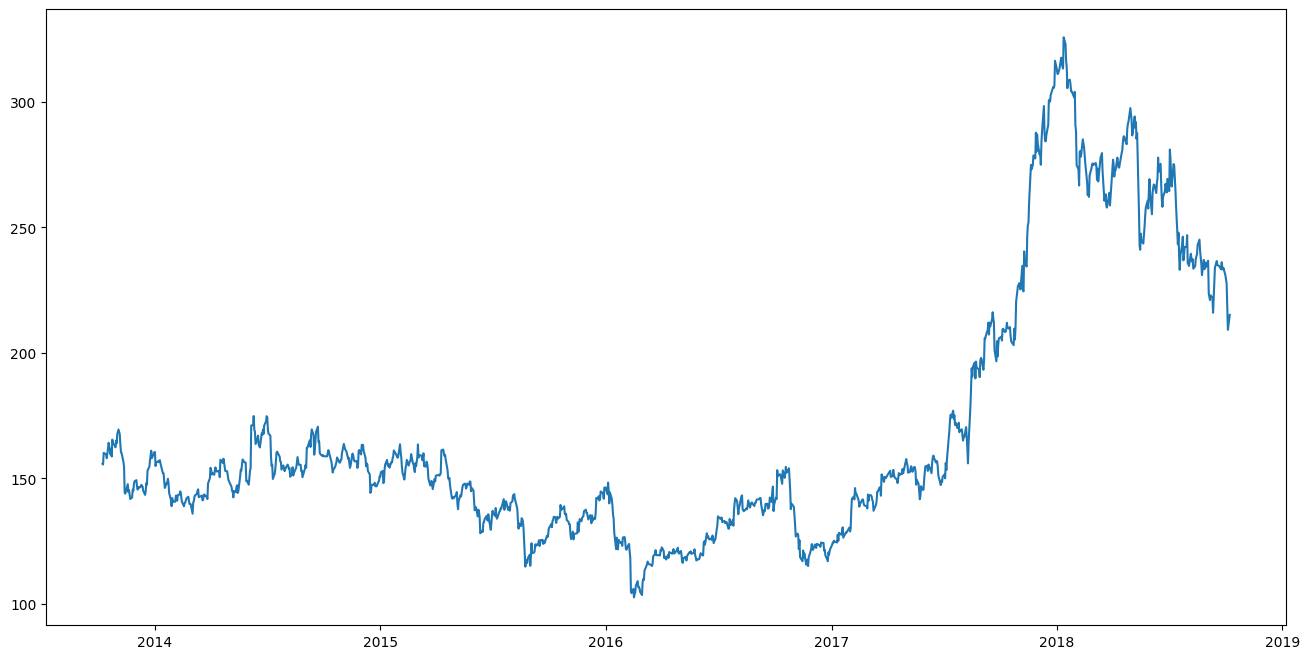

In [3]:
# Phân tích giá đóng cửa từ dataframe
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date'].values

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [4]:
# Sắp xếp dữ liệu theo thứ tự ngày tăng dần và lấy ra 2 cột Date và Close

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset.loc[i, "Date"]=data['Date'].iloc[i]
    new_dataset.loc[i, "Close"]=data["Close"].iloc[i]

In [5]:
# Chuẩn hóa dữ liệu
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

d:\Apps\Lib\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


In [6]:
# Dựng và huấn luyện mô hình RNN
rnn_model=Sequential()
rnn_model.add(SimpleRNN(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
rnn_model.add(SimpleRNN(units=50))
rnn_model.add(Dense(1))

rnn_model.compile(loss='mean_squared_error',optimizer='adam')
rnn_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

d:\Apps\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


927/927 - 9s - 10ms/step - loss: 0.0013


In [7]:
# Lấy mẫu từ dữ liệu để đưa ra dự đoán giá cổ phiếu bằng mô hình RNN:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=rnn_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [8]:
# Lưu mô hình RNN
rnn_model.save("saved_rnn_model.keras")

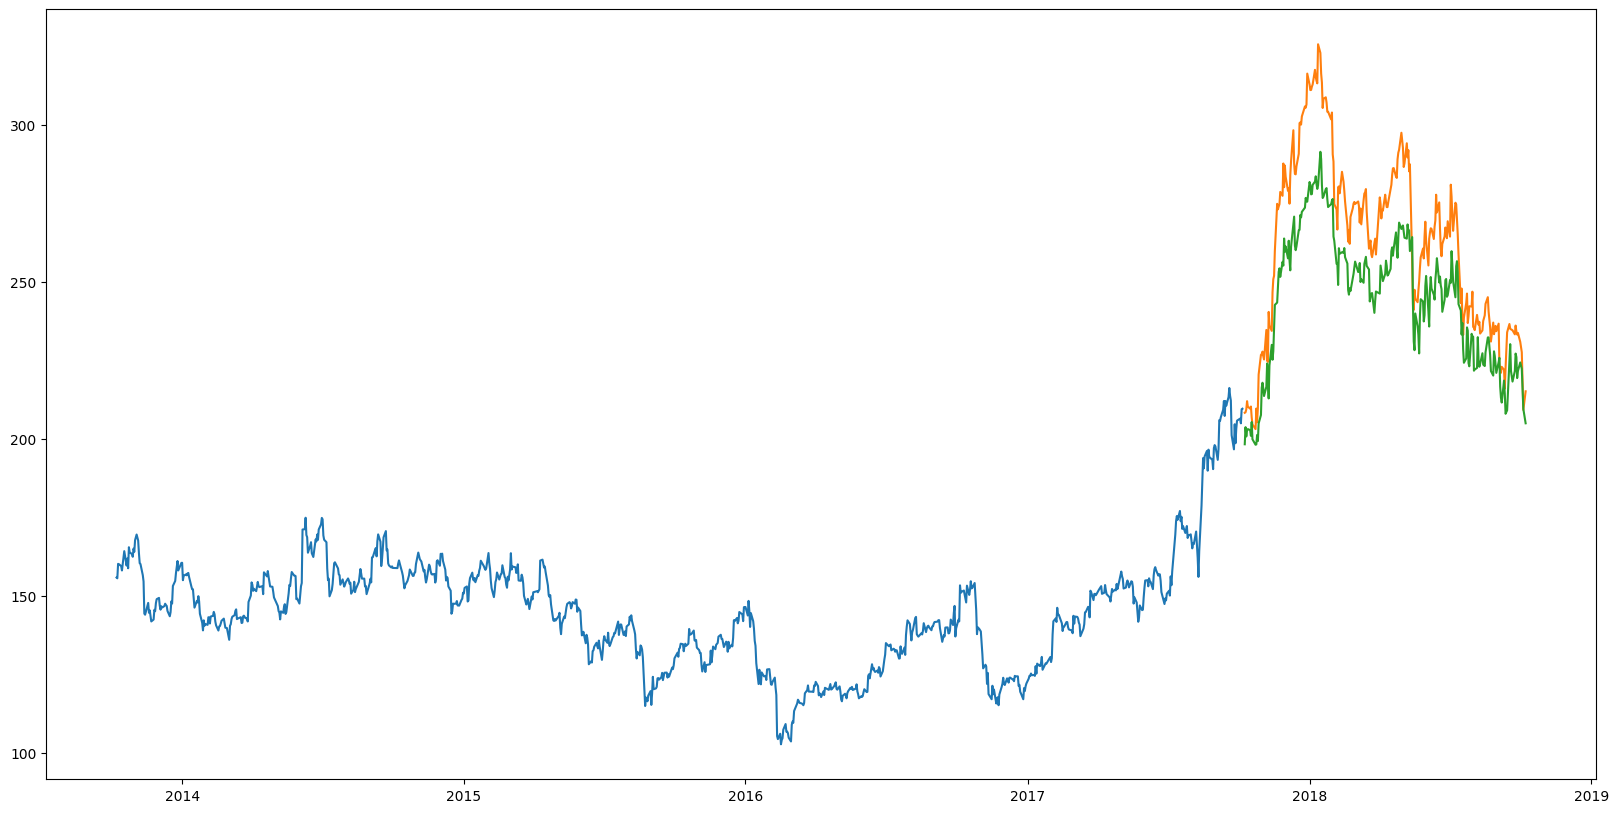

In [9]:
# Vẽ biểu đồ giá cổ phiếu dự đoán và thực tế
train_data=new_dataset[:987]
valid_data=new_dataset[987:].copy()
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
print(end = '')